Look at control of non-linear, LTV, LTI versions of bicycle model.
This bicycle model uses state x, y, psi, v, delta.

In [1]:
import numbers
import math

import numpy as np
import cv2 as cv
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.stats.qmc
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
import control
import control.matlab

import utility as util
import utility.npu

In [2]:
"""
c.g. - center of gravity
x - position on x-axis in global frame
y - position on y-axis in global frame
psi - angle between car longitudinal axis and x-axis of global frame  
v - velocity at center of gravity
delta - angle between car front wheel and car longitudinal axis
beta - angle between car longitudinal axis and velocity vector from c.g.
L - length of vehicle
l_r - length between back wheel and c.g.
l_f - length between front wheel and c.g.
"""

sin = math.sin
cos = math.cos
atan = math.atan
tan = math.tan

def get_beta(delta, l_r=0.5, L=1.0):
    if l_r == L:
        return delta
    else:
        return atan((l_r / L)*tan(delta))

def get_dbeta_ddelta(delta, l_r=0.5, L=1.0):
    if l_r == L:
        return 1
    else:
        tan2 = tan(delta)**2
        return (1 + tan2) / ((L / l_r) + (l_r / L)*tan2)

def bicycle_kinematics(t, x, u, params):
    l_r = params.get('l_r', 0.5)
    L = params.get('L', 1)
    psi   = x[2]
    v     = x[3]
    delta = x[4]
    u_1, u_2 = u[0], u[1]
    beta  = get_beta(delta, l_r=l_r, L=L)
    return np.array([
        v*cos(psi + beta), # dot x 
        v*sin(psi + beta), # dot y
        (v / L)*cos(beta)*tan(delta), # dot psi
        u_1, # dot v
        u_2, # dot delta
    ])

def get_state_matrix(x, y, psi, v, delta, l_r=0.5, L=1.0):
    beta   = get_beta(delta, l_r=l_r, L=L)
    dbeta  = get_dbeta_ddelta(delta, l_r=l_r, L=L)
    df3_dv = (1/L)*cos(beta)*tan(delta)
    df3_ddelta = (v/L)*(cos(beta)*(1 + tan(delta)**2) - sin(beta)*tan(delta)*dbeta)
    return np.array([
        # x, y, psi, v, delta
        [0, 0, -v*sin(psi + beta), cos(psi + beta), -v*sin(psi + beta)*dbeta],
        [0, 0,  v*cos(psi + beta), sin(psi + beta),  v*cos(psi + beta)*dbeta],
        [0, 0,                  0,          df3_dv,               df3_ddelta],
        [0, 0,                  0,               0,                        0],
        [0, 0,                  0,               0,                        0],
    ])

def get_input_matrix():
    return np.array([
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
    ]).T

def get_output_matrix():
    return np.array([
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
    ])

def get_feedforward_matrix():
    return np.array([
        [0, 0],
        [0, 0],
    ])

def cubic_interp_points(points):
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)
    spline = scipy.interpolate.CubicSpline(distance, points, axis=0)
    return spline, distance

def draw_cars(ax, X, lw, color='blue'):
    vertex_set = util.npu.vertices_of_bboxes(X[:, :2], X[:, 2], lw)
    for idx, vertices in enumerate(vertex_set):
        patch = patches.Polygon(vertices, closed=True, color=color, fc='none')
        ax.add_patch(patch)

def disp_errors(ax, timesteps, X, X_gt, color='blue', label=None):
    disp_errors = np.linalg.norm(X_gt[:, :2] - X[:, :2], axis=1)
    ax.plot(timesteps, disp_errors, color=color, label=label)

def rot_errors(ax, timesteps, X, X_gt, color='blue', label=None):
    rot_errors  = np.abs(X_gt[:, 2] - X[:, 2])
    ax.plot(timesteps, rot_errors, color=color, label=label)

In [19]:
def plot_linearization(initial_state, U, T, Ts, L=1.5, l_r=0.75):
    """
    initial_state : ndarray
        Initial state [x_0, y_0, psi_0, v_0, delta_0].
    U : ndarray
        Control inputs of shape (T, 2) [u_1, u_2]
    T : int
        Number of timesteps
    Ts : float
        Size of each timestep
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    axes = axes.ravel()
    timesteps = np.linspace(0, Ts*T, T + 1)
    mock_inputs = np.concatenate((U, np.array([0, 0])[None]), axis=0).T
    lw = np.array([L, 0.75*L])
    axes[2].plot(timesteps, mock_inputs[0])
    axes[3].plot(timesteps, mock_inputs[1])
    # axes[1].set_visible(False)
    
    # change the frame so that local frame has x_0 = y_0 = 0, psi_0 = 0
    x_0, y_0, psi_0, v_0, delta_0 = initial_state
    initial_state_local = initial_state.copy()
    initial_state_local[:3] = np.array([0, 0, 0])
    # rigid transformation to convert local to global frame
    M = np.array([
        [cos(psi_0), -sin(psi_0), x_0],
        [sin(psi_0),  cos(psi_0), y_0],
    ])
    def transform(X):
        points = np.pad(X[:, :2], [(0, 0), (0, 1)], constant_values=1)
        points = points @ M.T
        psis   = X[:, 2] + psi_0
        return np.concatenate((points, psis[..., None], X[:, 3:]), axis=1)

    io_bicycle_kinematics = control.NonlinearIOSystem(
                bicycle_kinematics, None,
                inputs=('u_1', 'u_2'),
                outputs=('x', 'y', 'psi', 'v', 'delta'),
                states=('x', 'y', 'psi', 'v', 'delta'),
                params={'l_r': l_r, 'L': L},
                name='bicycle_kinematics')
    _, states = control.input_output_response(
            io_bicycle_kinematics, timesteps, mock_inputs, initial_state)
    # ground truth state evolution with inputs 
    X_gt = states.T
    for ax in axes[:2]:
        ax.plot(*X_gt.T[:2], "-ko", label="bicycle kinemetics")
        draw_cars(ax, X_gt, lw, color="black")

    _, states = control.input_output_response(
            io_bicycle_kinematics, timesteps,
#             np.repeat(U[0][None], T + 1, axis=0).T, initial_state)
            np.zeros(mock_inputs.shape), initial_state)
    # state evolution with zero inputs
    X_less = states.T
    axes[0].plot(*X_less.T[:2], "-yo", label="no input")

    ###############
    # LTV version 1
    ###############

    ltv = []
    for i in range(T):
        A = get_state_matrix(*X_less[i], l_r=l_r, L=L)
        B = get_input_matrix()
        ltv.append((A, B))

    x = initial_state
    X = [x]
    for i in range(len(ltv)):
        A, B = ltv[i]
        d = X_less[i+1] - (A @ X_less[i])
        x = (A @ x) + (B @ U[i]) + d
        X.append(x)

    X = np.stack(X)
    axes[0].plot(*X.T[:2], "-go", label="LTV")
    draw_cars(axes[0], X, lw, color="green")
    disp_errors(axes[4], timesteps, X, X_gt, color="green", label="LTV")
    rot_errors(axes[5], timesteps, X, X_gt, color="green", label="LTV")
    
    ###############################
    # Plot LTI around current state
    ###############################
    
    # current has v equal to current vehicle velocity, zero control
    # get state-space representation that linearly approximates dynamical system
    A = get_state_matrix(*initial_state_local, l_r=l_r, L=L)
    B = get_input_matrix()
    C = get_output_matrix()
    D = get_feedforward_matrix()
    # discretize state-space
    sys = control.matlab.c2d(control.matlab.ss(A, B, C, D), Ts)
    A = np.array(sys.A)
    B = np.array(sys.B)

    x = initial_state_local
    X = [x]
    for i in range(T):
        x = (A @ x) + (B @ U[i])# - (A @ initial_state_local)
        X.append(x)

    X = np.stack(X)
    X = transform(X)
    axes[1].plot(*X.T[:2], "-bo", label="LTI")
    draw_cars(axes[1], X, lw, color="blue")
    disp_errors(axes[4], timesteps, X, X_gt, color="blue", label="LTI")
    rot_errors(axes[5], timesteps, X, X_gt, color="blue", label="LTI")
    
    axes[2].set_xlabel("seconds")
    axes[2].set_ylabel("$\dot{v} = u_1$")
    axes[2].set_title("$\dot{v} = u_1$ control input over time")
    axes[3].set_xlabel("seconds")
    axes[3].set_ylabel("$\dot{\delta} = u_2$")
    axes[3].set_title("$\dot{\delta} = u_2$ control input over time")
    axes[4].set_xlabel("seconds")
    axes[4].set_ylabel("errors")
    axes[4].set_title("error of linearization over time")
    axes[4].legend()
    axes[5].set_xlabel("seconds")
    axes[5].set_ylabel("errors")
    axes[5].set_title("longitudinal angle error")
    axes[5].legend()
    for ax in axes[2:]:
        ax.grid()

    for ax in axes[:2]:
        ax.legend()
        ax.set_aspect("equal")
#     fig.tight_layout()
    fig.suptitle("Comparing kinematic model and its linearization\n"
                 "with initial values\n"
                 f"$x_0 = $ {np.round(x_0, 2)},   "
                 f"$y_0 = $ {np.round(y_0, 2)},   "
                 f"$\psi_0 = $ {np.round(psi_0, 2)},   "
                 f"$v_0 = $ {np.round(v_0, 2)},   "
                 f"$\delta_0 = $ {np.round(delta_0, 2)}", size="x-large")

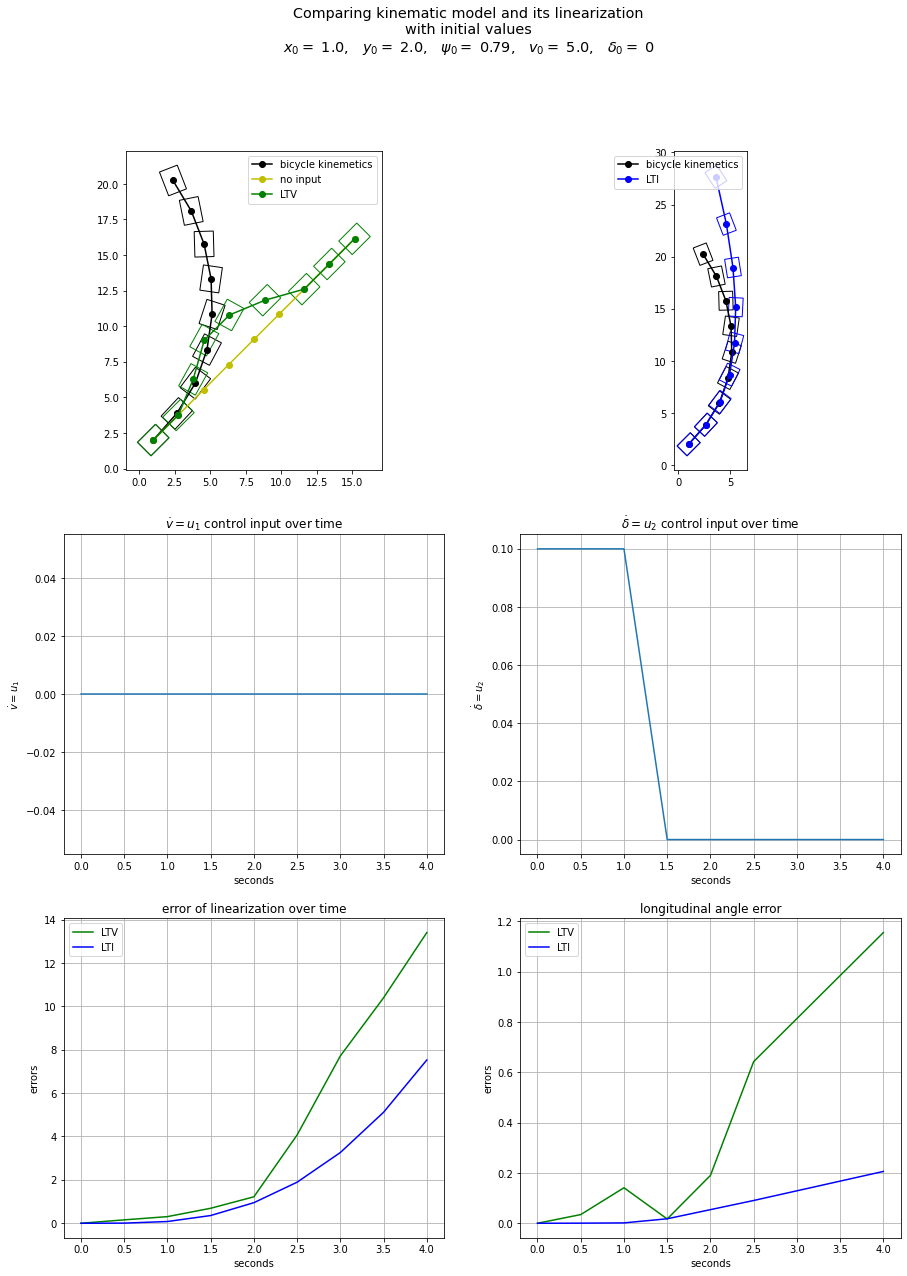

In [20]:
# initial state
x_0 = 1.
y_0 = 2.
psi_0 = np.pi/4
v_0 = 5.0
delta_0 = 0
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
l_r = 3.70
L = 1.79
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs: speed up and slight turn
# note that radians 0.5*np.pi / 6 = 0.26
U = np.array([
    [ 0  , 0.1],
    [ 0  , 0.1],
    [ 0  , 0.1],
    [ 0  , 0.0],
    [ 0  , 0.0],
    [ 0  , 0.0],
    [ 0  , 0.0],
    [ 0  , 0.0],
])

plot_linearization(initial_state, U, T, Ts, L=L, l_r=l_r)

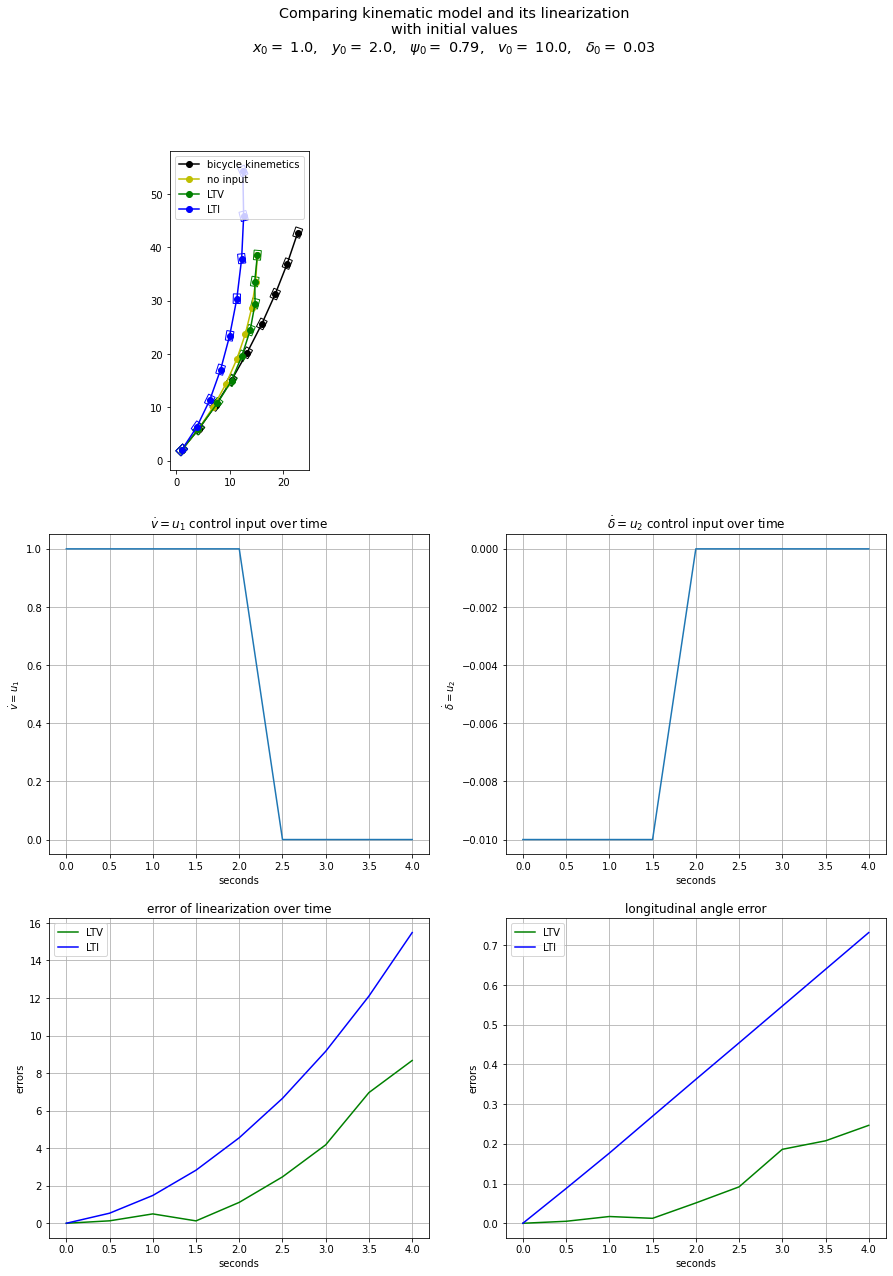

In [5]:
# initial state
x_0 = 1.
y_0 = 2.
psi_0 = np.pi/4
v_0 = 10.0
delta_0 = 0.02*0.5*np.pi
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
l_r = 3.70
L = 1.79
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs: speed up and slight turn
# note that radians 0.5*np.pi / 6 = 0.26
U = np.array([
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  , 0],
    [ 0  , 0],
    [ 0  , 0],
    [ 0  , 0],
])

plot_linearization(initial_state, U, T, Ts, L=L, l_r=l_r)

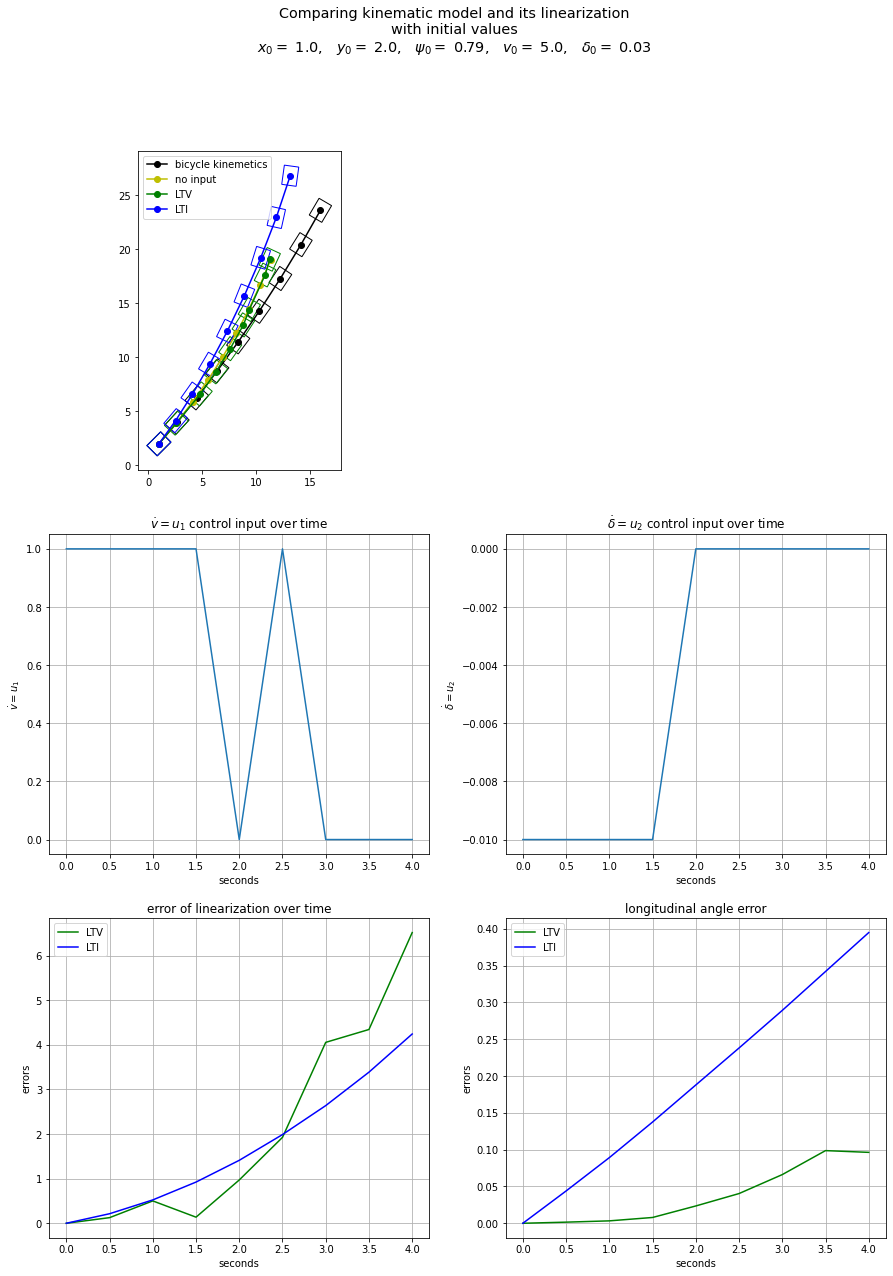

In [6]:
# initial state
x_0 = 1.
y_0 = 2.
psi_0 = np.pi/4
v_0 = 5.0
delta_0 = 0.02*0.5*np.pi
initial_state = np.array([x_0, y_0, psi_0, v_0, delta_0])
# scenario parameters
T = 8
Ts = 0.5
l_r = 3.70
L = 1.79
# inputs: speed up and slight turn
# note that radians 0.5*np.pi / 6 = 0.26
U = np.array([
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 0  , 0],
    [ 1  , 0],
    [ 0  , 0],
    [ 0  , 0],
])

plot_linearization(initial_state, U, T, Ts, L=L, l_r=l_r)

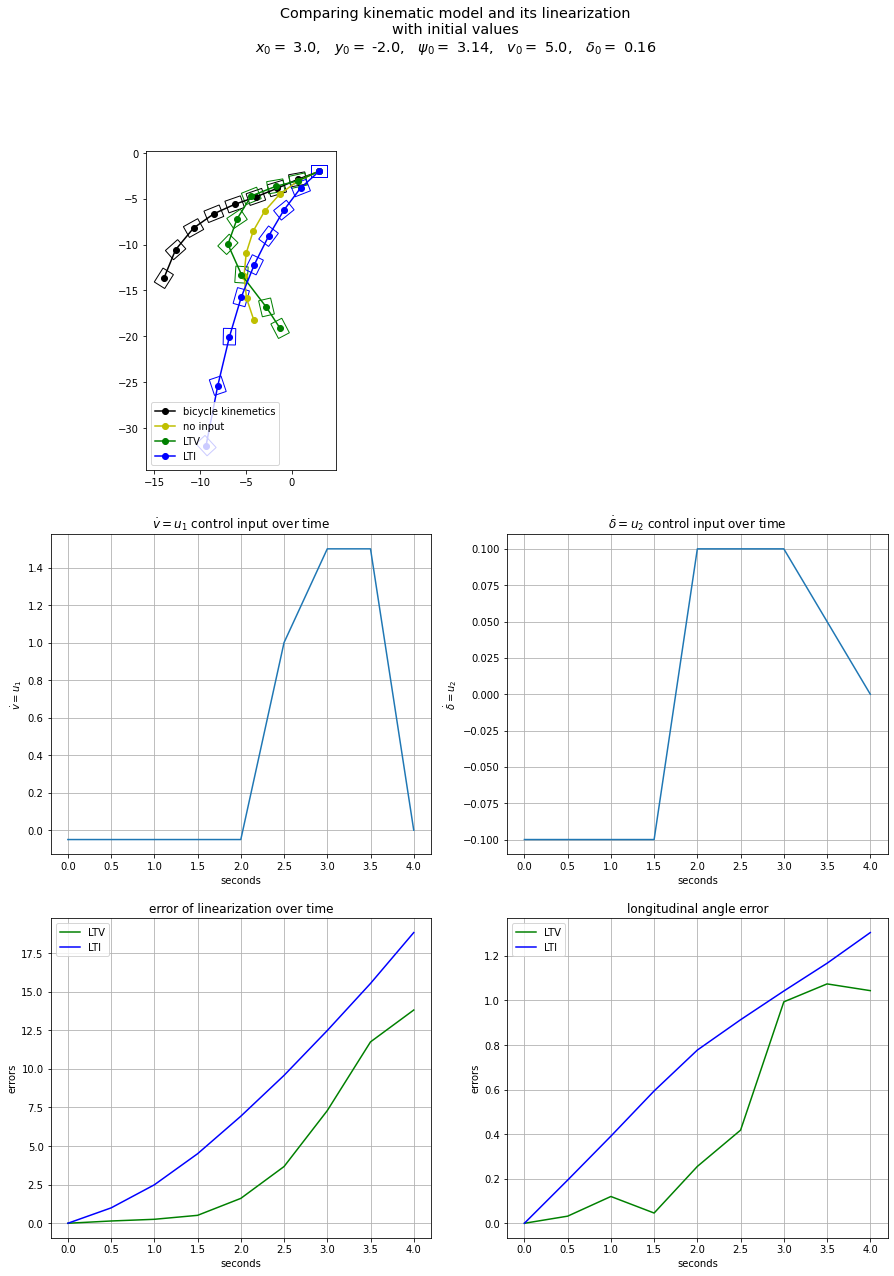

In [7]:
# initial state
x_0 = 3.
y_0 = -2.
psi_0 = np.pi
v_0 = 5.0
delta_0 = 0.05*np.pi
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
l_r = 3.70
L = 1.79
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs: slow down when right turn
# note that radians 0.5*np.pi / 6 = 0.26
U = np.array([
    [-0.05,-0.1],
    [-0.05,-0.1],
    [-0.05,-0.1],
    [-0.05,-0.1],
    [-0.05, 0.1],
    [ 1   ,  0.1],
    [ 1.5 ,  0.1],
    [ 1.5 , 0.05],
])

plot_linearization(initial_state, U, T, Ts, L=L, l_r=l_r)

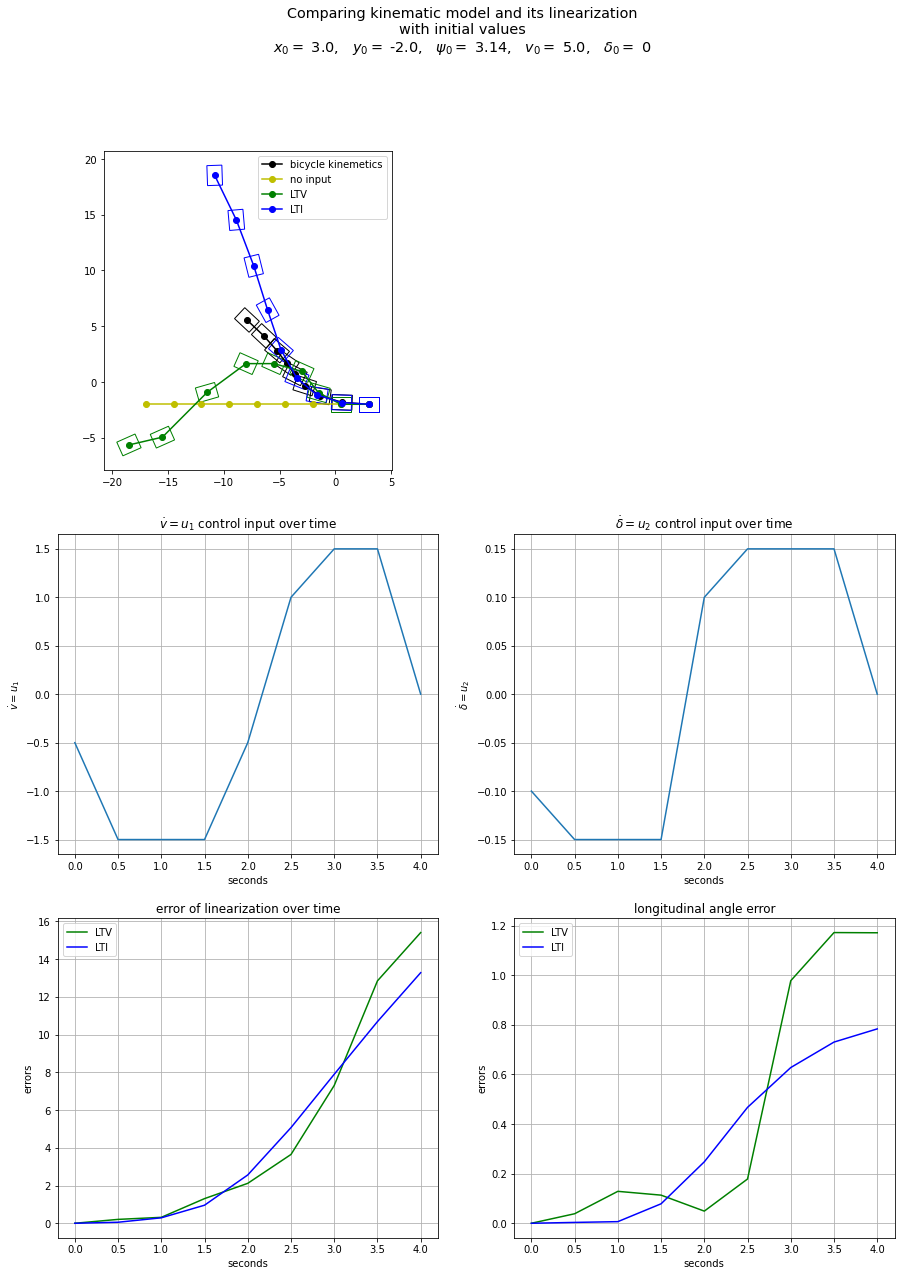

In [8]:
# initial state
x_0 = 3.
y_0 = -2.
psi_0 = np.pi
v_0 = 5.0
delta_0 = 0
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
l_r = 3.70
L = 1.79
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs: slow down when right turn
# note that radians 0.5*np.pi / 6 = 0.26
U = np.array([
    [-0.5,-0.1],
    [-1.5,-0.15],
    [-1.5,-0.15],
    [-1.5,-0.15],
    [-0.5, 0.1],
    [ 1   , 0.15],
    [ 1.5 , 0.15],
    [ 1.5 , 0.15],
])

plot_linearization(initial_state, U, T, Ts, L=L, l_r=l_r)

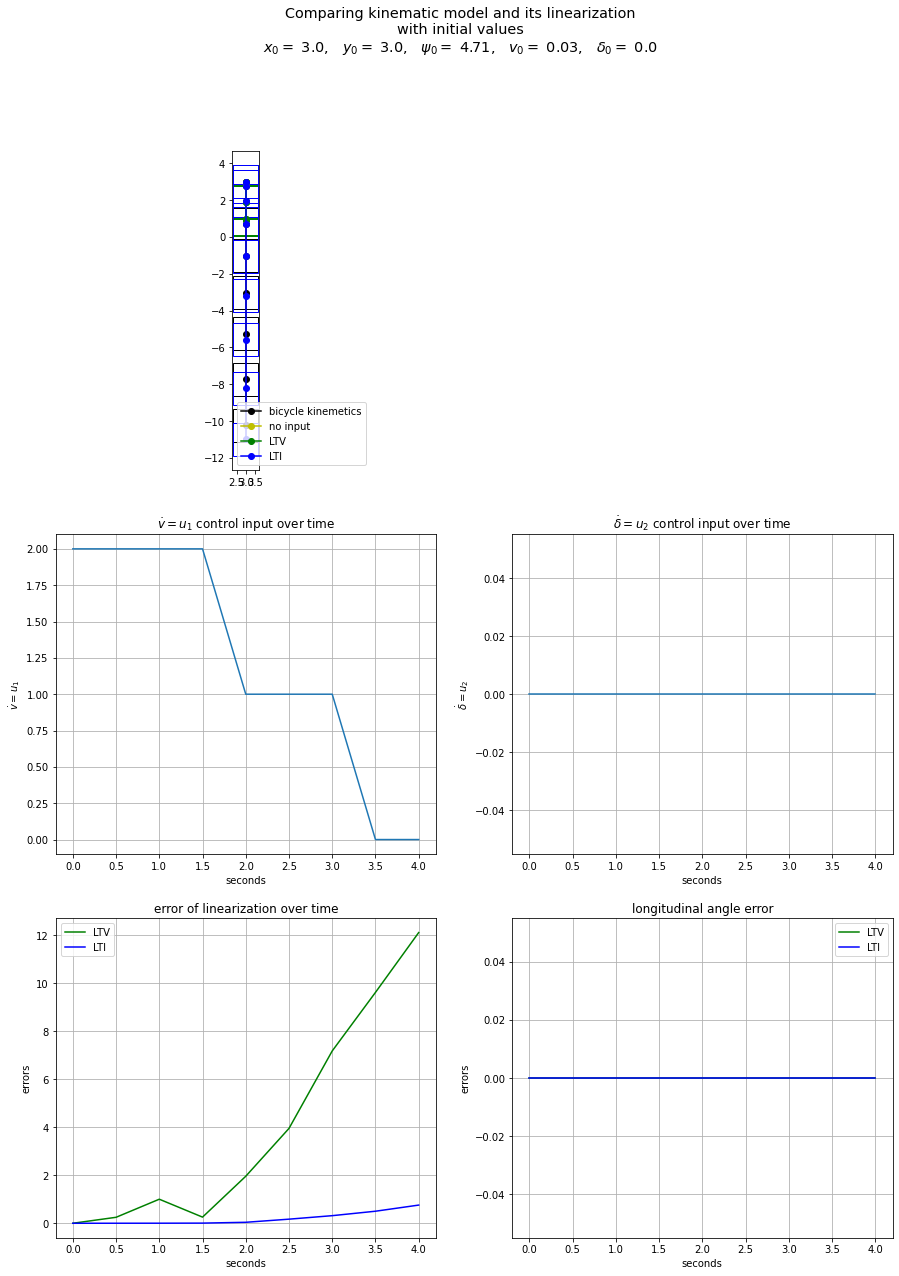

In [9]:
# initial state
x_0 = 3.
y_0 = 3.
psi_0 = (3/2)*np.pi
v_0 = 0.03
delta_0 = 0.
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs: slow down when right turn
# that radians 0.5*np.pi / 6 = 0.26
U = np.array([
    [2.0, 0],
    [2.0, 0],
    [2.0, 0],
    [2.0, 0],
    [1.0, 0],
    [1.0, 0],
    [1.0, 0],
    [0.0, 0],
])

plot_linearization(initial_state, U, T, Ts, L=L, l_r=l_r)

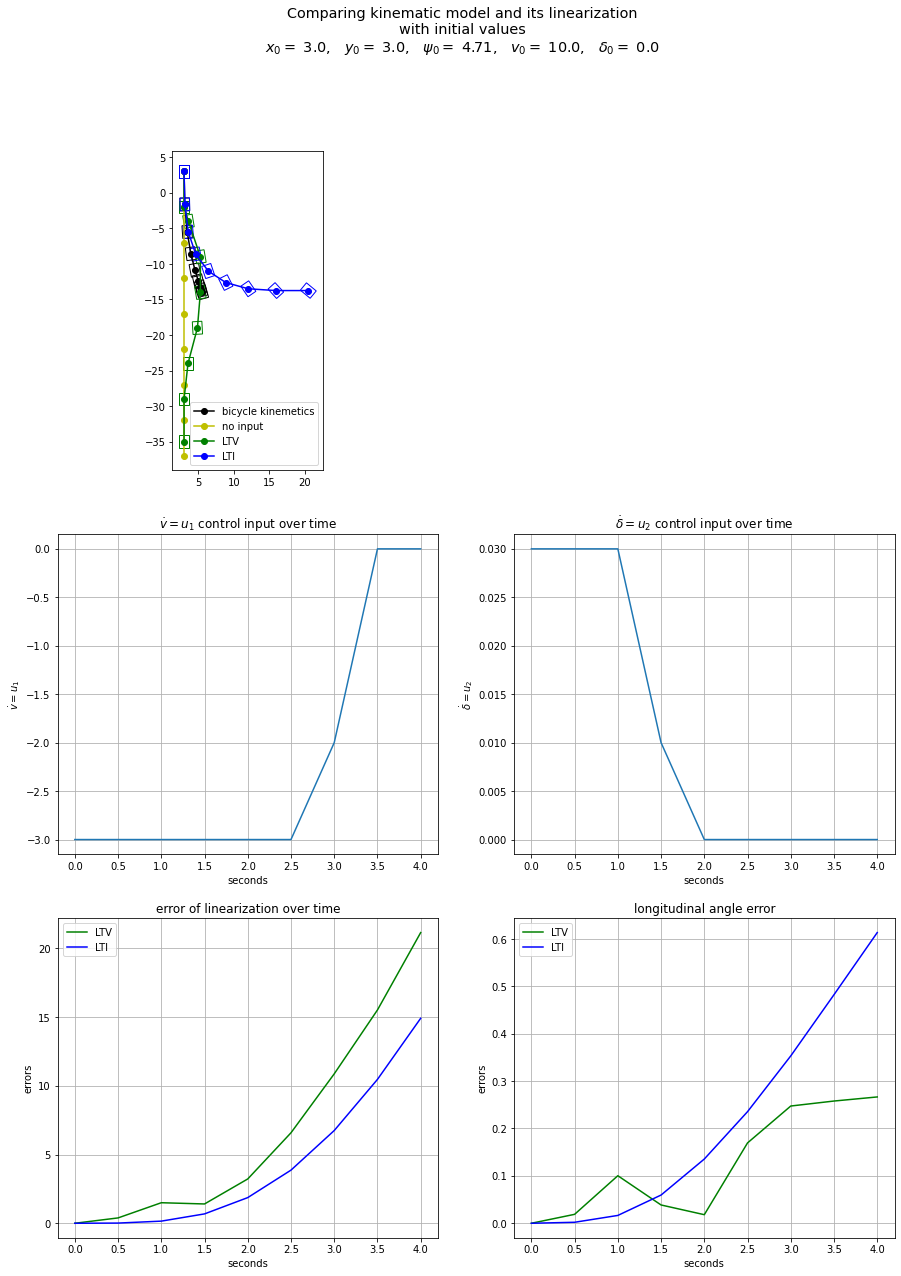

In [10]:
# initial state
x_0 = 3.
y_0 = 3.
psi_0 = (3/2)*np.pi
v_0 = 10.0
delta_0 = 0. # 0.02*0.5*np.pi
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs: slow down when right turn
# note that radians 0.5*np.pi / 6 = 0.26
U = np.array([
    [-3.0, 0.03],
    [-3.0, 0.03],
    [-3.0, 0.03],
    [-3.0, 0.01],
    [-3.0, 0],
    [-3.0, 0],
    [-2.0, 0],
    [ 0.0, 0],
])

plot_linearization(initial_state, U, T, Ts, L=L, l_r=l_r)